In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [7]:
def gen_lagged_data(metadata, data, last_date, lag, target_variable):
    last_date = pd.Timestamp(last_date)  # Ensure last_date is a Timestamp object
    data.index = pd.to_datetime(data.index)  # Ensure the index is a DatetimeIndex
    lagged_data = data.loc[data.index <= last_date, :].reset_index()
    for col in lagged_data.columns[1:]:
        if col in metadata.series.values:
            pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0]
            lagged_data.loc[(len(lagged_data) - pub_lag - lag):, col] = np.nan
        else:
            print(f"Warning: {col} not found in metadata")
    return lagged_data

# helper function, flatten a dataset for methods that don't do timeseries, extra columns for each lag
def flatten_data(data, target_variable, n_lags):
    # subset to only include rows with a value for the target variable
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]

    orig_index = flattened_data.index

    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = (tmp.date + pd.DateOffset(months=i)).apply(lambda x: x + pd.offsets.MonthEnd(0))
        print(tmp.date)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")

    return flattened_data

# helper function fill missings in a dataset with the mean from the training set
def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

# Data set up

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm
from pathlib import Path
import os

project_dir = Path(os.getcwd()).parent
print(project_dir)

# Define the path to the raw data folder relative to the project directory
data_dir = project_dir / 'data' / 'data_files' / 'processed_data'

# Read data
metadata = pd.read_csv(data_dir / 'meta_monthly_blocks_2.csv')
data = pd.read_csv(data_dir / 'deseasonalized_data.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date').sort_index()

# train and test dates
# Define date ranges
train_start_date = pd.to_datetime('1992-06-30')
test_start_date = pd.to_datetime("2018-06-30")
test_end_date = pd.to_datetime("2023-12-31")
dates = pd.date_range(start=test_start_date, end=test_end_date, freq='QE')

# Function to standardize a single column
def z_score(x):
    return (x - x.mean()) / x.std()

normalized = data.copy()

normalized.loc[:, normalized.columns != 'date'] = normalized.loc[:, normalized.columns != 'date'].apply(z_score)

data = normalized

target_variable = "China: GDP: Current Prices:PoP GROWTHRATE"

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(0, 4))

# test dataset
data = data.reset_index()
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

/Users/leyixu/Desktop/Nowcast


Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [5]:
test.tail()

,date,China: Financial Institutions: Total Deposits Balance: RMB:PoP GROWTHRATE,China: Industrial Added Value Above Designated Size: YoY,China: FAI: YTD:PoP GROWTHRATE,Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg,China: Urban Surveyed Unemployed Rate: Mean:PoP chg,China: No. of New Employed Persons in Urban Areas: YTD:PoP GROWTHRATE,China: Consumer Confidence Index: Employment:PoP chg,China: Consumer Satisfaction Index: Employment:PoP chg,China: Consumer Expectation Index: Employment:PoP chg,...,China: Central Parity Rate: USDCNY:PoP GROWTHRATE,USD/CNY: Spot Exchange Rate:PoP GROWTHRATE,China: Current Employment Sentiment Index:PoP chg,China: Employment Expectation Index:PoP chg,China: Index of Future Price Expectation:PoP chg,China: Industrial Capacity Utilization:PoP chg,China: Industrial Added Value Above Designated Size: Manufacturing: YoY,China: Business Climate Index:PoP chg,China: Business Climate Index: Spot Index:PoP chg,China: GDP: Current Prices:PoP GROWTHRATE
374,2023-08-31,0.060614,0.084946,-0.454623,-0.807297,-0.442230,0.019708,0.200391,0.188619,0.175460,...,-0.323149,-2.798896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375,2023-09-30,0.090164,-0.003022,-0.047017,-0.808093,-0.167179,0.003760,0.489073,0.419931,0.565222,...,0.000551,0.330018,-1.330039,-1.49796,-0.092557,0.315141,0.367862,0.224576,0.380008,-0.895276
376,2023-10-31,0.023585,0.047531,-0.002207,-1.798280,-0.055216,-0.262980,0.201125,0.500554,0.034175,...,0.026541,0.431369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,2023-11-30,0.039272,0.332335,-0.088482,-0.162833,0.261572,0.544832,-0.626020,-0.761091,-0.584051,...,-0.029257,0.990661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,2023-12-31,-0.762501,-0.033569,-1.287662,0.181796,1.141768,0.550101,-0.403374,-0.392253,-0.397772,...,0.098284,0.566556,-0.800754,-0.53815,-0.133040,0.482095,0.214684,0.504981,0.371575,-0.987230


# Training the model
The model is trained on a rolling basis.

In [8]:
# this cell is form information only. The process is repeated below for each test date.
transformed_train = mean_fill_dataset(test, test) # fill any missing values with the mean
transformed_train = flatten_data(transformed_train, target_variable, 4) # 4 means include 4 additional lags of each variable
# only keep quarterly observations and drop early observations with not enough history for lagged variables
transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)

# we can see that e.g. the variable `payems` now has 4 columns in the data, for each of the lags, and that the data now has one row per quarter
transformed_train.loc[:, [True] + list(transformed_train.columns[1:].str.contains("payems"))].tail()

0     1992-07-31
1     1992-08-31
2     1992-09-30
3     1992-10-31
4     1992-11-30
         ...    
373   2023-08-31
374   2023-09-30
375   2023-10-31
376   2023-11-30
377   2023-12-31
Name: date, Length: 378, dtype: datetime64[ns]
0     1992-08-31
1     1992-09-30
2     1992-10-31
3     1992-11-30
4     1992-12-31
         ...    
372   2023-08-31
373   2023-09-30
374   2023-10-31
375   2023-11-30
376   2023-12-31
Name: date, Length: 377, dtype: datetime64[ns]
0     1992-09-30
1     1992-10-31
2     1992-11-30
3     1992-12-31
4     1993-01-31
         ...    
371   2023-08-31
372   2023-09-30
373   2023-10-31
374   2023-11-30
375   2023-12-31
Name: date, Length: 376, dtype: datetime64[ns]
0     1992-10-31
1     1992-11-30
2     1992-12-31
3     1993-01-31
4     1993-02-28
         ...    
370   2023-08-31
371   2023-09-30
372   2023-10-31
373   2023-11-30
374   2023-12-31
Name: date, Length: 375, dtype: datetime64[ns]


,date
120,2022-12-31
121,2023-03-31
122,2023-06-30
123,2023-09-30
124,2023-12-31


# Testing the model on artificial data vintages

In [9]:
# dates in the test set
dates = pd.date_range(start=test_start_date, end=test_end_date, freq='QE')
print(dates)

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)
print(actuals)

DatetimeIndex(['2018-06-30', '2018-09-30', '2018-12-31', '2019-03-31',
               '2019-06-30', '2019-09-30', '2019-12-31', '2020-03-31',
               '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31',
               '2021-06-30', '2021-09-30', '2021-12-31', '2022-03-31',
               '2022-06-30', '2022-09-30', '2022-12-31', '2023-03-31',
               '2023-06-30', '2023-09-30', '2023-12-31'],
              dtype='datetime64[ns]', freq='QE-DEC')
[-0.6849544085679198, -0.6119740413652863, -0.4937444195250279, 0.14129623211839917, -0.5812296108463308, -0.8443222777951667, -0.5294662966751601, -3.899152536397687, 2.1768945393715646, -0.06971581206223539, -0.06798737852039938, 0.2916892526383249, 0.08690145628979003, -1.1500736573973596, -0.05162882489869327, -0.23359300515086423, -1.4837020948866197, -0.42376242422524707, -1.0668949285241651, 0.6237542346168391, -1.4183121861574457, -0.8952756846140533, -0.9872301403930471]


In [17]:
lags = [0, 1, 2, 3]

pred_dict = {k: [] for k in lags}
for date in dates:
    for lag in lags:
        # Calculate the cut-off date for training data, ensuring no future data is included
        train_cutoff_date = pd.to_datetime(date) - pd.DateOffset(months=lag + 1)
        
        # Filter the training data to include only data up to the cutoff date
        train = test.loc[test.date <= train_cutoff_date].copy()
        train = train.reset_index(drop=True)
        
        # Prepare the training data
        transformed_train = mean_fill_dataset(train, train) # fill any missing values with the mean
        transformed_train = flatten_data(transformed_train, target_variable, 4) # 4 means include 4 additional lags of each variable
        # only keep quarterly observations and drop early observations with not enough history for lagged variables
        transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)
        
        # Train the model on this non-contaminated data
        model = ElasticNet(alpha = 0.1, l1_ratio = 0.3)
        x = transformed_train.drop(["date", target_variable], axis=1)
        y = transformed_train[target_variable]
        model.fit(x, y)
        
        # Generate the data available for this date at this artificial vintage
        tmp_data = gen_lagged_data(metadata, test, date, lag, target_variable)
        
        # Ensure the 'date' column is correctly formatted
        if 'date' in tmp_data.columns:
            tmp_data['date'] = pd.to_datetime(tmp_data['date'], errors='coerce')
        else:
            raise ValueError("The 'tmp_data' DataFrame does not have a 'date' column.")
        
        # Get data in format necessary for model
        tmp_data = mean_fill_dataset(train, tmp_data) # fill with the mean of the training set
        tmp_data = flatten_data(tmp_data, target_variable, 4)
        
        # Ensure tmp_data has the same columns as transformed_train
        tmp_data = tmp_data.reindex(columns=transformed_train.columns, fill_value=0)
        print(tmp_data)
        
        # Extract only the row corresponding to the current date
        x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
        
        # The predict function will give a whole dataframe, only interested in the prediction for this date
        pred = model.predict(x)[0]
        pred_dict[lag].append(pred)


0     1992-07-31
1     1992-08-31
2     1992-09-30
3     1992-10-31
4     1992-11-30
         ...    
305   2017-12-31
306   2018-01-31
307   2018-02-28
308   2018-03-31
309   2018-04-30
Name: date, Length: 310, dtype: datetime64[ns]
0     1992-08-31
1     1992-09-30
2     1992-10-31
3     1992-11-30
4     1992-12-31
         ...    
304   2017-12-31
305   2018-01-31
306   2018-02-28
307   2018-03-31
308   2018-04-30
Name: date, Length: 309, dtype: datetime64[ns]
0     1992-09-30
1     1992-10-31
2     1992-11-30
3     1992-12-31
4     1993-01-31
         ...    
303   2017-12-31
304   2018-01-31
305   2018-02-28
306   2018-03-31
307   2018-04-30
Name: date, Length: 308, dtype: datetime64[ns]
0     1992-10-31
1     1992-11-30
2     1992-12-31
3     1993-01-31
4     1993-02-28
         ...    
302   2017-12-31
303   2018-01-31
304   2018-02-28
305   2018-03-31
306   2018-04-30
Name: date, Length: 307, dtype: datetime64[ns]
0     1992-07-31
1     1992-08-31
2     1992-09-30
3     1992-10

# Assess and visualize model performance

In [18]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2))
    }, index=[0])
    performance = pd.concat([performance, tmp]).reset_index(drop=True)
performance.round(4)

/var/folders/ns/hcbvd_hd3gxfr2y183d8csgr0000gn/T/ipykernel_19867/687125535.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = pd.concat([performance, tmp]).reset_index(drop=True)


,Vintage,RMSE
0,0,0.9895
1,1,0.9924
2,2,1.0463
3,3,1.0446


<Axes: >

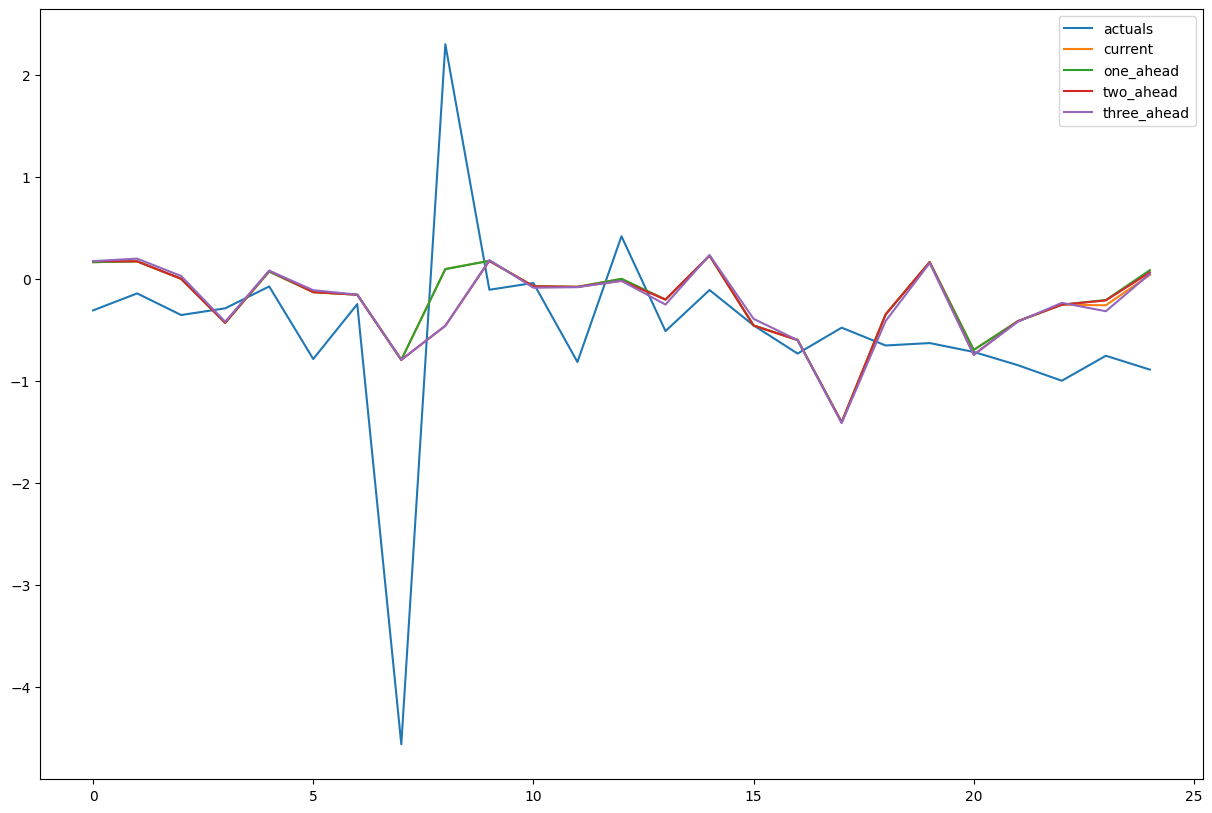

In [19]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals,
    "current":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2],
    "three_ahead":pred_dict[3]
}).plot()

In [11]:
import pandas as pd
from datetime import datetime

# Convert pred_dict to a DataFrame
df = pd.DataFrame(pred_dict)

# Add a date column
df['date'] = dates

# Reorder columns to have date first
columns = ['date'] + [col for col in df.columns if col != 'date']
df = df[columns]

# Save to CSV with timestamp
filename = f'elastic_net_deseason.csv'
df.to_csv(project_dir / 'results' / filename, index=False)

# Hyperparameter tuning
grid search is used to find the best hyperparameters for the model. Adjust as needed. The previous illustration is based on the best parameters found.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Define a custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create a scorer object for GridSearchCV
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define the grid of hyperparameters
param_grid = {
    'alpha': [0.05, 0.08, 0.1, 0.13, 0.15],
    'l1_ratio': [0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
}
# Initialize a dictionary to store the metrics
metrics = {'date': [], 'lag': [], 'mse': [], 'mae': [], 'r2': []}

for date in dates:
    train = test.loc[test.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10], :] 
    transformed_train = mean_fill_dataset(train, train)
    transformed_train = flatten_data(transformed_train, target_variable, 4)
    transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3, 6, 9, 12]), :].dropna(axis=0, how="any").reset_index(drop=True)

    model = ElasticNet()
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmse_scorer)
    
    x = transformed_train.drop(["date", target_variable], axis=1)
    y = transformed_train[target_variable]
    grid_search.fit(x, y)

    best_model = grid_search.best_estimator_

    for lag in lags:
        tmp_data = gen_lagged_data(metadata, test, date, lag)
        tmp_data = mean_fill_dataset(train, tmp_data)
        tmp_data = flatten_data(tmp_data, target_variable, 4)
        x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
        
        pred = best_model.predict(x)[0]

        # Append metrics
        actual = test.loc[test.date == date, target_variable].values[0]
        mse = mean_squared_error([actual], [pred])
        mae = mean_absolute_error([actual], [pred])
        r2 = r2_score([actual], [pred])

        metrics['date'].append(date)
        metrics['lag'].append(lag)
        metrics['mse'].append(mse)
        metrics['mae'].append(mae)
        metrics['r2'].append(r2)


In [ ]:
print(grid_search.best_params_)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the metrics dictionary to a DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)

# Plot the MSE over time for different lags
plt.figure(figsize=(10, 6))
for lag in lags:
    lag_metrics = metrics_df[metrics_df['lag'] == lag]
    plt.plot(lag_metrics['date'], lag_metrics['mse'], label=f'Lag {lag}')
plt.xlabel('Date')
plt.ylabel('Mean Squared Error')
plt.title('MSE over Time for Different Lags')
plt.legend()
plt.show()

# Plot the MAE over time for different lags
plt.figure(figsize=(10, 6))
for lag in lags:
    lag_metrics = metrics_df[metrics_df['lag'] == lag]
    plt.plot(lag_metrics['date'], lag_metrics['mae'], label=f'Lag {lag}')
plt.xlabel('Date')
plt.ylabel('Mean Absolute Error')
plt.title('MAE over Time for Different Lags')
plt.legend()
plt.show()


In [ ]:
import joblib

# Save the best model
best_model_filename = 'best_elastic_net_model.pkl'
joblib.dump(best_model, best_model_filename)
print(f"Best model saved as {best_model_filename}")

# Assuming you used GridSearchCV or RandomizedSearchCV for tuning
best_params = grid_search.best_params_
print("Best parameters selected:", best_params)


Best model saved as best_elastic_net_model.pkl
Best parameters selected: {'alpha': 0.05, 'l1_ratio': 0.1}
